In [2]:
%load_ext autoreload

In [3]:
import os
import json
import cv2
import glob
import swifter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle, Rectangle
#sns.set(style='darkgrid')
sns.set(style='darkgrid', context='notebook',font_scale=1.5)

In [4]:
%autoreload
import sys
sys.path.insert(0,'../')
from scripts.loader import *
import mytools as tl

# Datos

In [5]:
data_path = os.path.join('..', 'Datasets', 'Interiors')
resp_path = os.path.join(data_path, 'responses')
subj_path = os.path.join(data_path, 'human_scanpaths')
figs_path = os.path.join(os.getcwd(), 'figs')

In [6]:
resp_path

'../Datasets/Interiors/responses'

In [7]:
trials_data    = load_trials_properties(os.path.join(subj_path,'..', 'trials_properties.json'))
subjs_response = load_human_scanpaths(os.path.join(resp_path, 'human_scanpaths'), human_subject='all')
responses_data = tl.get_responses_features(subjs_response)
#responses_data = responses_data[responses_data.response_x <= 1024]
responses_data.head()

subj                              img  max_fixations  scanpath_length  \
0    41      grayscale_11_opensource.jpg             13               10   
1    41  grayscale_18_housebeautiful.jpg              9               10   
2    41          grayscale_100_oliva.jpg              5                3   
3    41           grayscale_17_oliva.jpg              3                2   
4    41  grayscale_16_housebeautiful.jpg              3                4   

   target_found  target_found_response  response_size  distance_to_target  \
0         False                  False             29          266.810794   
1         False                  False             47          329.200547   
2          True                  False             19          202.054448   
3         False                  False             35          297.692795   
4         False                  False             19          568.198029   

   distance_to_last_fix  delta_time_response  response_x  response_y  \
0            213.164661            49.599536       486.0       447.0   
1            411.615026             9.666707       520.0       538.0   
2            204.544005             5.633140       714.0       218.0   
3            208.923431             4.266648       433.0       316.0   
4            223.650531             2.900187       762.0       442.0   

   target_bbox_x  target_bbox_y  response_target_relative_x  \
0            228            559                      -258.0   
1            797            400                       277.0   
2            713            381                        -1.0   
3            186            490                      -247.0   
4            158            421                      -604.0   

   response_target_relative_y  
0                       112.0  
1                      -138.0  
2                       163.0  
3                       174.0  
4                       -21.0

# Performance acumulada

## A mano

In [8]:
df=responses_data.groupby(['subj', 'max_fixations']).mean()['target_found']
sns.boxplot(data=df.reset_index(), x='max_fixations', y='target_found')

<AxesSubplot:xlabel='max_fixations', ylabel='target_found'>

In [9]:
def cumulative_mean_performance_response(df, max_fix_key ='max_fixations', use_response=True):
    
    print('Using target found online')
    so = df.groupby(['subj', max_fix_key])['target_found'].sum()
    co = df.groupby(['subj', max_fix_key])['target_found'].count()
    perf_o = (so/co).groupby(['max_fixations']).agg(['mean', 'std'])
    
    if use_response:
        sr = df.groupby(['subj', max_fix_key])['target_found_response'].sum()
        cr = df.groupby(['subj', max_fix_key])['target_found_response'].count()
        perf_r = (sr/cr).groupby(['max_fixations']).agg(['mean', 'std'])
        # join with online target found
        perf_o = perf_o.join(perf_r, lsuffix='_online', rsuffix='_response')
        df['target_found_online_response'] = df['target_found'] & df['target_found_response']
        so_r = df.groupby(['subj', max_fix_key])['target_found_online_response'].sum()
        co_r = df.groupby(['subj', max_fix_key])['target_found_online_response'].count()
        perf_o_r = (so_r/co_r).groupby(['max_fixations']).agg(['mean', 'std'])
        # join with online target found
        perf_o = perf_o.join(perf_o_r)
        perf_o.rename(columns={'mean': 'mean_online_response', 'std': 'std_online_response'}, inplace=True)
        #perf_o.reset_index(inplace=True)
        
    return perf_o
 
aux  = cumulative_mean_performance_response(responses_data).reset_index()

_, ax = plt.subplots(1,1,figsize=(10,7))
ax.errorbar(aux['max_fixations'], aux['mean_online'], yerr = aux['std_online'], 
            label ='target found online', capsize=4)
ax.fill_between(aux['max_fixations'], 
                aux['mean_online']-aux['std_online'], 
                aux['mean_online']+aux['std_online'],
                alpha=0.4)

ax.errorbar(aux['max_fixations'], aux['mean_response'], yerr = aux['std_response'],
            label = 'target found response', capsize=4)
ax.fill_between(aux['max_fixations'], 
                aux['mean_response']-aux['std_response'], 
                aux['mean_response']+aux['std_response'], 
                alpha=0.4)

ax.errorbar(aux['max_fixations'], aux['mean_online_response'], yerr = aux['std_online_response'],
            label = 'target found online and response', capsize=4)
ax.fill_between(aux['max_fixations'],
                aux['mean_online_response']-aux['std_online_response'], 
                aux['mean_online_response']+aux['std_online_response'], alpha=0.4)

ax.set_ylim(0,1)
ax.legend()

plt.savefig(os.path.join(figs_path, f'lineplot_performance_responses.png'))

Using target found online


In [10]:
responses_data.scanpath_length.value_counts()

4     1433
3     1172
5     1017
6      783
2      482
8      467
7      464
9      421
10     313
12     228
13     213
11     179
14     141
Name: scanpath_length, dtype: int64

## Usando las funciones del repo

No handles with labels found to put in legend.


[Cumulative performance] Computing human mean for Interiors dataset


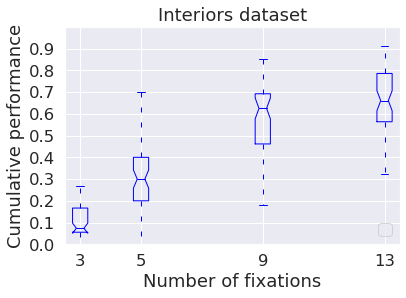

In [11]:
%autoreload
from Metrics.scripts.cumulative_performance import CumulativePerformance
perf = CumulativePerformance(dataset_name='Interiors', number_of_images=134, max_scanpath_length=15, compute=True)
#perf.compute_cumulative_performance(subjs_response[42])
perf.add_human_mean(humans_scanpaths_dir=os.path.join(resp_path, 'human_scanpaths'), humans_color='blue')
#perf.add_human_mean(humans_scanpaths_dir=subj_path, humans_color='blue')
perf.plot(save_path=figs_path)

# Performance: scanpath + respuesta

In [12]:
results_path = '../Results/Interiors_Responses_dataset/nnIBS/subjects_predictions'

In [13]:
def load_results_responses(res_path = '../Results/Interiors_Responses_dataset/nnIBS/subjects_predictions/'):
    """
    Function to load the results of the Interiors Responses dataset. 
    Recorre el path dado buscando los archivos que continen los resultados de las metricas fijacion a fijacion con el formato dado por el script de nnIBS.
    Los archivos son de la forma: 'subject_XX_results_fixations.json'
    Cada uno de estos archivos contiene el valor de la metrica correspondiente para esa sacada forzando el modelo a seguir al sujeto. 
    Carga los resultados en dos dataframes y devuelve dos listas con los errores encontrados.

    Args:
        res_path (str, optional): Path to the dataset. Defaults to '../Results/Interiors_Responses_dataset/nnIBS/subjects_predictions/'.

    Returns:
        dout1 (pd.DataFrame): Devuelve un dataframe con las medidas resumen de las metricas, con y sin la ultima fijacion(respuesta) 
                                y solo de las ultimas dos sacadas (descontando la respuesta).
        dout2 (pd.DataFrame): _description_
        missing (list): _description_
        onefix (list): _description_
    """
    dout = []
    dout2 = []
    missing = []
    onefix = []
    for subj_file in sorted([file for file in os.listdir(res_path) if 'fixations' in file]):
        with open(os.path.join(res_path, subj_file)) as json_file:
            d = json.load(json_file)
            for img in d.keys():
                for metric in d[img].keys():
                    val   = list(d[img][metric].values())
                    # number of saccades + 1 (response) = number of fixations (
                    n_fix = len(val)
                    # 'mean_response'
                    avg_r = np.mean(val)
                    # 'mean_no_response'
                    avg_nr = np.mean(val[:-1])
                    # 'mean_last_two'
                    avg_last_fix = np.mean(val[-3:-1])
                    # log erros: length 0, nans or one fix
                    if len(list(val))==0:
                        missing.append((subj_file, img, metric, 'length 0'))
                    elif np.nan in val:
                        missing.append((subj_file, img, metric, 'nans'))
                    elif len(val) ==1:
                        onefix.append((subj_file, img, metric, 'one fix'))    
                    dout.append({'subj':int(subj_file[8:10]), 'img':img , 'metric':metric, 'n_fix':n_fix,
                                 'response':val[-1], 'mean_response': avg_r, 'mean_no_response':avg_nr, 'mean_last_two':avg_last_fix})
                    for i,f in enumerate(val):
                        if i==len(val)-1:
                            nsacc = 'response'
                        elif i==len(val)-2:
                            nsacc = 'last'
                        else:
                            nsacc = i
                        dout2.append({'subj':int(subj_file[8:10]), 'img':img , 'metric':metric, 'n_fix':n_fix,
                                 'val':val[i], 'nsacc': nsacc, 'mean_response': avg_r, 'mean_no_response':avg_nr, 'mean_last_two':avg_last_fix})
                      
    return pd.DataFrame(dout), pd.DataFrame(dout2), missing, onefix

df_out, df_out_all, miss, onefix = load_results_responses(res_path=results_path)
print(f'Cantidad de datos con errores: {len(miss)}')
print(f'Cantidad de datos con una fijación: {len(onefix)}')

Cantidad de datos con errores: 0
Cantidad de datos con una fijación: 0


In [14]:
# No hay errores pero sin embargo hay NaNs
print(f'Cantidad de datos que no puede mirar la respuesta ni ultimas dos fijaciones: {df_out.mean_no_response.isna().sum()}')

Cantidad de datos que no puede mirar la respuesta ni ultimas dos fijaciones: 0


In [15]:
# Cargo ademas
sdf = tl.create_scanpaths_df(subjs_response, use_response=True).sort_values(by=['subj', 'img'])
sdf.head()

subj                              img fix_order      x      y     t  \
40850     1          grayscale_100_oliva.jpg         0  435.3  350.9  1653   
40851     1          grayscale_100_oliva.jpg         1  508.0  372.0   107   
40852     1          grayscale_100_oliva.jpg         2  752.0  410.8   144   
40853     1          grayscale_100_oliva.jpg         r  731.0  419.0     9   
41599     1  grayscale_10_housebeautiful.jpg         0  380.4  372.0  1816   

       target_found  
40850          True  
40851          True  
40852          True  
40853          True  
41599          True

In [16]:
df_out_all.query('subj==1 and img=="grayscale_100_oliva.jpg"')

subj                      img metric  n_fix       val     nsacc  \
2928     1  grayscale_100_oliva.jpg    AUC      3  0.908203         0   
2929     1  grayscale_100_oliva.jpg    AUC      3  0.995443      last   
2930     1  grayscale_100_oliva.jpg    AUC      3  0.995443  response   
2931     1  grayscale_100_oliva.jpg    NSS      3  1.548923         0   
2932     1  grayscale_100_oliva.jpg    NSS      3  6.074760      last   
2933     1  grayscale_100_oliva.jpg    NSS      3  8.739270  response   
2934     1  grayscale_100_oliva.jpg     IG      3 -4.007397         0   
2935     1  grayscale_100_oliva.jpg     IG      3  1.528849      last   
2936     1  grayscale_100_oliva.jpg     IG      3  0.120821  response   
2937     1  grayscale_100_oliva.jpg     LL      3  0.566395         0   
2938     1  grayscale_100_oliva.jpg     LL      3  1.466303      last   
2939     1  grayscale_100_oliva.jpg     LL      3  0.241720  response   

      mean_response  mean_no_response  mean_last_two  
2928       0.966363          0.951823       0.951823  
2929       0.966363          0.951823       0.951823  
2930       0.966363          0.951823       0.951823  
2931       5.454318          3.811842       3.811842  
2932       5.454318          3.811842       3.811842  
2933       5.454318          3.811842       3.811842  
2934      -0.785909         -1.239274      -1.239274  
2935      -0.785909         -1.239274      -1.239274  
2936      -0.785909         -1.239274      -1.239274  
2937       0.758139          1.016349       1.016349  
2938       0.758139          1.016349       1.016349  
2939       0.758139          1.016349       1.016349

In [17]:
df_out.shape, df_out_all.shape, len(onefix)

((29252, 8), (173384, 9), 0)

In [18]:
df_out.columns, df_out_all.columns

(Index(['subj', 'img', 'metric', 'n_fix', 'response', 'mean_response',
        'mean_no_response', 'mean_last_two'],
       dtype='object'),
 Index(['subj', 'img', 'metric', 'n_fix', 'val', 'nsacc', 'mean_response',
        'mean_no_response', 'mean_last_two'],
       dtype='object'))

## Crear columna distancia a la fijación del último mapa


### Sanity check

In [19]:
# Comprobamos si nfix (que seria mas un nsac) que se lee del json coincide con la cantidad de csv guardados por sacada
aux1 = df_out_all[df_out_all.metric=='AUC'].groupby(['subj','img']).apply(len)
aux2 = (aux1 == df_out_all[df_out_all.metric=='AUC'].groupby(['subj','img']).apply(lambda x: x.iloc[0,:].n_fix))
aux2.sum() == aux2.shape[0]

True

### Mapas de sacadas y distancia al modelo

In [20]:
subjs_response = load_human_scanpaths(os.path.join(resp_path, 'human_scanpaths'), human_subject='all')
responses_data = tl.get_responses_features(subjs_response).set_index(['subj', 'img'])
responses_data.head()

max_fixations  scanpath_length  \
subj img                                                               
41   grayscale_11_opensource.jpg                 13               10   
     grayscale_18_housebeautiful.jpg              9               10   
     grayscale_100_oliva.jpg                      5                3   
     grayscale_17_oliva.jpg                       3                2   
     grayscale_16_housebeautiful.jpg              3                4   

                                      target_found  target_found_response  \
subj img                                                                    
41   grayscale_11_opensource.jpg             False                  False   
     grayscale_18_housebeautiful.jpg         False                  False   
     grayscale_100_oliva.jpg                  True                  False   
     grayscale_17_oliva.jpg                  False                  False   
     grayscale_16_housebeautiful.jpg         False                  False   

                                      response_size  distance_to_target  \
subj img                                                                  
41   grayscale_11_opensource.jpg                 29          266.810794   
     grayscale_18_housebeautiful.jpg             47          329.200547   
     grayscale_100_oliva.jpg                     19          202.054448   
     grayscale_17_oliva.jpg                      35          297.692795   
     grayscale_16_housebeautiful.jpg             19          568.198029   

                                      distance_to_last_fix  \
subj img                                                     
41   grayscale_11_opensource.jpg                213.164661   
     grayscale_18_housebeautiful.jpg            411.615026   
     grayscale_100_oliva.jpg                    204.544005   
     grayscale_17_oliva.jpg                     208.923431   
     grayscale_16_housebeautiful.jpg            223.650531   

                                      delta_time_response  response_x  \
subj img                                                                
41   grayscale_11_opensource.jpg                49.599536       486.0   
     grayscale_18_housebeautiful.jpg             9.666707       520.0   
     grayscale_100_oliva.jpg                     5.633140       714.0   
     grayscale_17_oliva.jpg                      4.266648       433.0   
     grayscale_16_housebeautiful.jpg             2.900187       762.0   

                                      response_y  target_bbox_x  \
subj img                                                          
41   grayscale_11_opensource.jpg           447.0            228   
     grayscale_18_housebeautiful.jpg       538.0            797   
     grayscale_100_oliva.jpg               218.0            713   
     grayscale_17_oliva.jpg                316.0            186   
     grayscale_16_housebeautiful.jpg       442.0            158   

                                      target_bbox_y  \
subj img                                              
41   grayscale_11_opensource.jpg                559   
     grayscale_18_housebeautiful.jpg            400   
     grayscale_100_oliva.jpg                    381   
     grayscale_17_oliva.jpg                     490   
     grayscale_16_housebeautiful.jpg            421   

                                      response_target_relative_x  \
subj img                                                           
41   grayscale_11_opensource.jpg                          -258.0   
     grayscale_18_housebeautiful.jpg                       277.0   
     grayscale_100_oliva.jpg                                -1.0   
     grayscale_17_oliva.jpg                               -247.0   
     grayscale_16_housebeautiful.jpg                      -604.0   

                                      response_target_relative_y  
subj img                                                          
41   grayscale_11_opensource.jpg                     

In [21]:
from visualsearch.grid import Grid

def map_fix_to_grid_(fix, img_w, img_h, grid):
    # Mapea una fijacion a la grilla de la imagen
    new_size = grid.size()
    fix_mapped_x = tl.rescale_coordinate(fix[1], img_w, new_size[1])
    fix_mapped_y = tl.rescale_coordinate(fix[0], img_h, new_size[0])
    return np.array([fix_mapped_y,fix_mapped_x])

def get_fixation_maps_path_(subj, img, path):
    # Devuelve los mapas de probabilidad calculados para cada fijacion del modelo siguiendo al sujeto
    name = f'subject_{subj:02d}'
    p = os.path.join(path, name, 'probability_maps', img[:-4])
    fix_map_paths_ = sorted(os.listdir(p))
    return [os.path.join(p,fix_map_) for fix_map_ in fix_map_paths_]

def get_fixation_from_extended_(subj, img, path, nsacc=-1):
    # Devuelve una fijacion del scanpath extendido del sujeto y la imagen
    name = f'subject_{subj:02d}'
    p = os.path.join(path, name, 'Subject_scanpaths.json')
    d = load_dict_from_json(p)
    fix_x = d[img]['X'][nsacc]
    fix_y = d[img]['Y'][nsacc]
    return np.array([fix_y, fix_x])

def get_standarized_fixation_val_(fix, map, mean, std):
    # Dada una fijacion y un mapa de probabilidad, devuelve el valor de la fijacion estandarizado
    return (map[fix[0], fix[1]]-mean)/std

def load_fixation_maps(subj, img, path, fix_plot=False):
    # Carga los mapas de probabilidad de cada fijacion del modelo siguiendo a un sujeto
    maps = get_fixation_maps_path_(subj, img, path)
    fix_maps = [pd.read_csv(m).values for m in maps]
    print(f'Total saccades: {len(fix_maps)}')
    if fix_plot:
        last_map = fix_maps[fix_plot]*255
        with sns.plotting_context("talk"):
            plt.imshow(last_map)
    return np.array(fix_maps)

def get_model_next_fix_(maps, nsacc):
    # Calcular la siguiente fijacion del modelo
    return np.array(np.unravel_index(np.argmax(maps[nsacc,], axis=None), maps[nsacc,].shape))

def get_map_range_(maps, nsacc):
    # Devuelve el rango de valores del mapa de probabilidad
    return maps[nsacc].min(), maps[nsacc,].max()
    
def distance_between_fix_(subj, img, nsacc, path, img_w = 1024, img_h = 768):
    # TODO: Tengo que agregarle que cuando nsacc sea -2 compare no contra la respuesta sino contra la ultima fijacion
    if nsacc == 'last': 
        nsacc = -2
    elif nsacc == 'response': 
        nsacc = -1
    else:
        return -1
    subject_fix = get_fixation_from_extended_(subj, img, path, nsacc) 
    # me traigo la fijacion del modelo
    maps      = load_fixation_maps(subj, img, path)
    model_fix = get_model_next_fix_(maps, nsacc)
    maps_mean, maps_std = maps.mean(axis=(1,2)), maps.std(axis=(1,2))
    nss_subj  = get_standarized_fixation_val_(subject_fix, maps[nsacc,:,:], maps_mean[nsacc], maps_std[nsacc])
    nss_model = get_standarized_fixation_val_(model_fix,   maps[nsacc,:,:], maps_mean[nsacc], maps_std[nsacc])
    map_min, map_max = get_map_range_(maps, nsacc)
    return np.linalg.norm(model_fix-subject_fix), nss_subj, nss_model, map_min, map_max, maps_mean[nsacc], maps_std[nsacc]
    #return np.linalg.norm(model_fix-subject_fix), maps, subject_fix, model_fix
    
# para hacerlo mas rápido tendría que cagar todo de una e iterar sobre un gruopby (subj,img)


In [1]:
# Crashea vscode
#from pandarallel import pandarallel
#pandarallel.initialize(nb_workers=4, progress_bar=True)
#df = df_out_all[df_out_all.nsacc.isin(['last','response'])].copy()
#subj_model_distance_aux = df.parallel_apply(lambda x: distance_between_fix_(x.subj, x.img, x.nsacc, results_path), axis=1)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [22]:
# Test function
#a = distance_between_fix_(15, 'grayscale_1_housebeautiful.jpg', 'last', results_path)
#a[4]

#get_fixation_from_extended_(3, 'grayscale_1_housebeautiful.jpg', results_path, -2)
#load_fixation_maps(3, 'grayscale_1_housebeautiful.jpg', results_path)
#get_model_next_fix_(maps, -2)

#a, a_m, a_sf, a_mf = distance_between_fix_(15, 'grayscale_1_housebeautiful.jpg', 'last', results_path)
#plt.imshow(a_m[-1]), a_sf, a_m[-1].shape, a_m[-1][19,31], a_m[-1, a_sf[0], a_sf[1]]

In [23]:
# pruebo con pandas apply
df = df_out_all[df_out_all.nsacc.isin(['last','response'])].copy()
subj_model_distance_aux = df.apply(lambda x: distance_between_fix_(x.subj, x.img, x.nsacc, results_path), axis=1)

Total saccades: 8
Total saccades: 8
Total saccades: 8
Total saccades: 8
Total saccades: 8
Total saccades: 8
Total saccades: 8
Total saccades: 8
Total saccades: 6
Total saccades: 6
Total saccades: 6
Total saccades: 6
Total saccades: 6
Total saccades: 6
Total saccades: 6
Total saccades: 6
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 10
Total saccades: 10
Total saccades: 10
Total saccades: 10
Total saccades: 10
Total saccades: 10
Total saccades: 10
Total saccades: 10
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
Total saccades: 5
To

In [24]:
aux = pd.DataFrame(subj_model_distance_aux.tolist(), index=df.index, columns=['subj_model_distance', 'nss_subj', 'nss_model'
                                                                                ,'map_min', 'map_max', 'map_mean', 'map_std'])
df_new = pd.concat([df,aux],axis=1)
df = df_new.copy()
del(df_new)

In [25]:
df_out_all.shape, df.shape

((173384, 9), (58504, 16))

In [26]:
df.sample(10)

subj                              img metric  n_fix       val  \
4367       2           grayscale_24_oliva.jpg     LL      4 -0.283216   
71478     23           grayscale_55_oliva.jpg     LL      9  0.259749   
148379    49           grayscale_94_oliva.jpg     LL     11 -0.000365   
25432      9      grayscale_18_opensource.jpg     IG      6  1.297891   
4325       2  grayscale_23_housebeautiful.jpg     IG      5  2.096896   
134093    45  grayscale_12_housebeautiful.jpg    AUC      2  0.999349   
154527    51           grayscale_81_oliva.jpg     IG      4  4.986181   
60024     20      grayscale_27_opensource.jpg     IG      6 -1.327205   
131354    44           grayscale_17_oliva.jpg     LL      3  0.277085   
58594     20          grayscale_6_kitchen.jpg     IG      4  1.107063   

           nsacc  mean_response  mean_no_response  mean_last_two  \
4367    response       0.373439          0.592324       0.987438   
71478       last       0.298287          0.327361       0.311319   
148379  response      -0.140496         -0.154509       0.321030   
25432       last       2.256649          2.632812       1.167281   
4325        last       0.898221          0.746353       1.318606   
134093  response       0.984375          0.969401       0.969401   
154527  response       2.060768          1.085631       1.990097   
60024       last      -0.680711         -0.341762      -1.019017   
131354      last       0.537130          0.809501       0.809501   
58594       last       0.325377          0.457052       0.590086   

        subj_model_distance  nss_subj  nss_model   map_min   map_max  \
4367              15.811388 -0.382893   4.650783  0.007724  0.036812   
71478              4.123106  1.435319   6.350574  0.042655  0.091729   
148379             9.848858 -0.159311   5.860615  0.026481  0.050958   
25432              7.000000  3.567549   6.436331  0.015718  0.065895   
4325              11.704700  0.427414   4.333076  0.004350  0.032423   
134093             0.000000  9.199388   9.199388  0.158660  0.286826   
154527            17.117243 -0.232430   5.087926  0.006694  0.045578   
60024              1.000000  6.280807   6.697560  0.018830  0.068617   
131354            12.041595  0.378723   5.323681  0.007669  0.047197   
58594              8.602325 -0.370062   5.342705  0.009368  0.066795   

        map_mean   map_std  
4367    0.011631  0.005414  
71478   0.048979  0.006732  
148379  0.030567  0.003479  
25432   0.019971  0.007135  
4325    0.008608  0.005496  
134093  0.174528  0.012207  
154527  0.011056  0.006785  
60024   0.023442  0.006745  
131354  0.011869  0.006636  
58594   0.014304  0.009825

In [27]:
df[(df.nsacc=='response')].tail()

subj                      img metric  n_fix       val     nsacc  \
173375    57   grayscale_98_oliva.jpg     LL     11  0.312412  response   
173377    57  grayscale_100_oliva.jpg    AUC      2  0.986328  response   
173379    57  grayscale_100_oliva.jpg    NSS      2  5.096384  response   
173381    57  grayscale_100_oliva.jpg     IG      2 -0.227532  response   
173383    57  grayscale_100_oliva.jpg     LL      2  0.297598  response   

        mean_response  mean_no_response  mean_last_two  subj_model_distance  \
173375       0.526821          0.548262      -0.024519            18.027756   
173377       0.988281          0.990234       0.990234             2.000000   
173379       4.736651          4.376917       4.376917             2.000000   
173381       0.694803          1.617139       1.617139             2.000000   
173383       0.767166          1.236733       1.236733             2.000000   

        nss_subj  nss_model   map_min   map_max  map_mean   map_std  
173375  0.255894   5.156511  0.041432  0.057124  0.046301  0.002099  
173377  5.096384   9.308159  0.233052  0.361601  0.254931  0.011460  
173379  5.096384   9.308159  0.233052  0.361601  0.254931  0.011460  
173381  5.096384   9.308159  0.233052  0.361601  0.254931  0.011460  
173383  5.096384   9.308159  0.233052  0.361601  0.254931  0.011460

### Merge con el resto de la data

In [28]:
# merge con todos los datos - me quedan nans en las distancias hasta la proxima
print(df.shape, responses_data.shape)
df_all = df.merge(responses_data, on=['subj','img'])
print(df_all.shape, responses_data.shape)
print(df_all.columns)
df_all.isna().sum()

(58504, 16) (7313, 14)
(58504, 30) (7313, 14)
Index(['subj', 'img', 'metric', 'n_fix', 'val', 'nsacc', 'mean_response',
       'mean_no_response', 'mean_last_two', 'subj_model_distance', 'nss_subj',
       'nss_model', 'map_min', 'map_max', 'map_mean', 'map_std',
       'max_fixations', 'scanpath_length', 'target_found',
       'target_found_response', 'response_size', 'distance_to_target',
       'distance_to_last_fix', 'delta_time_response', 'response_x',
       'response_y', 'target_bbox_x', 'target_bbox_y',
       'response_target_relative_x', 'response_target_relative_y'],
      dtype='object')


subj                          0
img                           0
metric                        0
n_fix                         0
val                           0
nsacc                         0
mean_response                 0
mean_no_response              0
mean_last_two                 0
subj_model_distance           0
nss_subj                      0
nss_model                     0
map_min                       0
map_max                       0
map_mean                      0
map_std                       0
max_fixations                 0
scanpath_length               0
target_found                  0
target_found_response         0
response_size                 0
distance_to_target            0
distance_to_last_fix          0
delta_time_response           0
response_x                    0
response_y                    0
target_bbox_x                 0
target_bbox_y                 0
response_target_relative_x    0
response_target_relative_y    0
dtype: int64

In [29]:
cols = ['subj', 'img', 'metric', 'nsacc','subj_model_distance',  'nss_subj',
       'nss_model', 'map_min', 'map_max', 'map_mean', 'map_std',
       'max_fixations', 'scanpath_length', 'target_found',
       'target_found_response', 'response_size', 'distance_to_target',
       'distance_to_last_fix', 'delta_time_response', 'response_x',
       'response_y']
df_all = df_all[cols].merge(df_out_all, on=['subj','img','metric', 'nsacc'], how='outer')
df_all.head(10)

subj                             img metric     nsacc  subj_model_distance  \
0     1  grayscale_1_housebeautiful.jpg    AUC      last             1.000000   
1     1  grayscale_1_housebeautiful.jpg    AUC  response             1.414214   
2     1  grayscale_1_housebeautiful.jpg    NSS      last             1.000000   
3     1  grayscale_1_housebeautiful.jpg    NSS  response             1.414214   
4     1  grayscale_1_housebeautiful.jpg     IG      last             1.000000   
5     1  grayscale_1_housebeautiful.jpg     IG  response             1.414214   
6     1  grayscale_1_housebeautiful.jpg     LL      last             1.000000   
7     1  grayscale_1_housebeautiful.jpg     LL  response             1.414214   
8     1         grayscale_1_kitchen.jpg    AUC      last            16.124515   
9     1         grayscale_1_kitchen.jpg    AUC  response             0.000000   

   nss_subj  nss_model   map_min   map_max  map_mean  ...  distance_to_target  \
0  5.124688   7.814689  0.281429  0.326727  0.305867  ...           21.540659   
1  0.351543   0.433908  0.425230  0.462614  0.461476  ...           21.540659   
2  5.124688   7.814689  0.281429  0.326727  0.305867  ...           21.540659   
3  0.351543   0.433908  0.425230  0.462614  0.461476  ...           21.540659   
4  5.124688   7.814689  0.281429  0.326727  0.305867  ...           21.540659   
5  0.351543   0.433908  0.425230  0.462614  0.461476  ...           21.540659   
6  5.124688   7.814689  0.281429  0.326727  0.305867  ...           21.540659   
7  0.351543   0.433908  0.425230  0.462614  0.461476  ...           21.540659   
8  0.811794   6.146613  0.010120  0.053109  0.014385  ...           10.630146   
9  9.522324   9.522324  0.095728  0.158703  0.105442  ...           10.630146   

   distance_to_last_fix  delta_time_response response_x response_y  n_fix  \
0             78.365809             0.466865      186.0      199.0      8   
1             78.365809             0.466865      186.0      199.0      8   
2             78.365809             0.466865      186.0      199.0      8   
3             78.365809             0.466865      186.0      199.0      8   
4             78.365809             0.466865      186.0      199.0      8   
5             78.365809             0.466865      186.0      199.0      8   
6             78.365809             0.466865      186.0      199.0      8   
7             78.365809             0.466865      186.0      199.0      8   
8             59.573148             0.666899      883.0      313.0      6   
9             59.573148             0.666899      883.0      313.0      6   

        val  mean_response  mean_no_response  mean_last_two  
0  0.991536       0.888021          0.872675       0.966146  
1  0.995443       0.888021          0.872675       0.966146  
2  5.124688       1.340039          1.481253       3.569346  
3  0.351543       1.340039          1.481253       3.569346  
4  1.183885      -0.050026         -0.339807       1.063493  
5  1.978444      -0.050026         -0.339807       1.063493  
6  0.063124       0.251722          0.287270       0.238036  
7  0.002880       0.251722          0.287270       0.238036  
8  0.867839       0.774306          0.729297       0.749349  
9  0.999349       0.774306          0.729297       0.749349  

[10 rows x 26 columns]

In [30]:
df_all.shape

(173384, 26)

In [34]:
# la cantidad de nans tendria que coincidir con df_out_all.shape - df.shape (lo cual lo hace)
df_all.isna().sum(axis=0)

subj                          0
img                           0
metric                        0
nsacc                         0
subj_model_distance      114880
nss_subj                 114880
nss_model                114880
map_min                  114880
map_max                  114880
map_mean                 114880
map_std                  114880
max_fixations            114880
scanpath_length          114880
target_found             114880
target_found_response    114880
response_size            114880
distance_to_target       114880
distance_to_last_fix     114880
delta_time_response      114880
response_x               114880
response_y               114880
n_fix                         0
val                           0
mean_response                 0
mean_no_response              0
mean_last_two                 0
found_category                0
dtype: int64

In [32]:
def cat_trial(row):
    if row['target_found'] and row['target_found_response']:
        return 'TFO & TFR'
    elif ~row['target_found'] and row['target_found_response']:
        return '~TFO & TFR'
    elif row['target_found'] and ~row['target_found_response']:
        return 'TFO & ~TFR'
    elif ~row['target_found'] and ~row['target_found_response']:
        return '~TFO & ~TFR'
    else:
        return 'ERROR'

responses_data_auxiliar_col = []
for idx, row in df_all.iterrows():
    responses_data_auxiliar_col.append(cat_trial(row))
df_all['found_category'] = responses_data_auxiliar_col

In [33]:
df_all.shape, df_all.columns

((173384, 27),
 Index(['subj', 'img', 'metric', 'nsacc', 'subj_model_distance', 'nss_subj',
        'nss_model', 'map_min', 'map_max', 'map_mean', 'map_std',
        'max_fixations', 'scanpath_length', 'target_found',
        'target_found_response', 'response_size', 'distance_to_target',
        'distance_to_last_fix', 'delta_time_response', 'response_x',
        'response_y', 'n_fix', 'val', 'mean_response', 'mean_no_response',
        'mean_last_two', 'found_category'],
       dtype='object'))

### Save and load

In [ ]:
# por las dudas lo guardamos en cache para ahorrarnos los 15 min previos
df_all.to_csv('./cache/df_con_distancias_11-10.csv')
# df_all = pd.read_csv('./cache/df_con_distancias_11-10.csv', header=0, index_col=0)

In [84]:
df_all[['val','nsacc','metric','subj_model_distance']].groupby(['val','nsacc','metric']).mean()

subj_model_distance
val        nsacc    metric                     
-5.103353  response IG                 7.615773
-5.029937  5        IG                      NaN
-5.023016  response IG                 9.219544
-4.929325  response IG                 8.602325
-4.832325  7        IG                      NaN
...                                         ...
 42.220672 5        IG                      NaN
 42.245952 3        IG                      NaN
 42.248675 2        IG                      NaN
 42.314223 3        IG                      NaN
 42.335169 last     IG                17.464249

[118687 rows x 1 columns]

## Comparando con el script

In [46]:
df_test = tl.create_scanpaths_df_metrics_models(df_out_all, responses_data=responses_data, results_path=results_path)

Adding metrics for models...

Merging with responses data...

Adding category of trials...



In [89]:
my_cols = ['subj', 'img', 'metric', 'nsacc','subj_model_distance',  'nss_subj',
       'nss_model', 'map_min', 'map_max', 'map_mean', 'map_std',
       'max_fixations', 'scanpath_length', 'target_found',
       'target_found_response', 'response_size', 'distance_to_target',
       'distance_to_last_fix', 'delta_time_response', 'response_x',
       'response_y']
df_test_merge = df_test[my_cols].merge(df_out_all, on=['subj','img','metric', 'nsacc'], how='outer').sort_values(by=['subj','img','metric', 'nsacc'])
df_test_merge.tail(20)

subj                    img metric     nsacc  subj_model_distance  \
171839    57  grayscale_9_other.jpg     LL         6                  NaN   
171840    57  grayscale_9_other.jpg     LL         7                  NaN   
171841    57  grayscale_9_other.jpg     LL         8                  NaN   
171842    57  grayscale_9_other.jpg     LL         9                  NaN   
171843    57  grayscale_9_other.jpg     LL        10                  NaN   
57710     57  grayscale_9_other.jpg     LL      last             3.162278   
57711     57  grayscale_9_other.jpg     LL  response             5.830952   
171811    57  grayscale_9_other.jpg    NSS         0                  NaN   
171812    57  grayscale_9_other.jpg    NSS         1                  NaN   
171813    57  grayscale_9_other.jpg    NSS         2                  NaN   
171814    57  grayscale_9_other.jpg    NSS         3                  NaN   
171815    57  grayscale_9_other.jpg    NSS         4                  NaN   
171816    57  grayscale_9_other.jpg    NSS         5                  NaN   
171817    57  grayscale_9_other.jpg    NSS         6                  NaN   
171818    57  grayscale_9_other.jpg    NSS         7                  NaN   
171819    57  grayscale_9_other.jpg    NSS         8                  NaN   
171820    57  grayscale_9_other.jpg    NSS         9                  NaN   
171821    57  grayscale_9_other.jpg    NSS        10                  NaN   
57706     57  grayscale_9_other.jpg    NSS      last             3.162278   
57707     57  grayscale_9_other.jpg    NSS  response             5.830952   

        nss_subj  nss_model   map_min   map_max  map_mean  ...  \
171839       NaN        NaN       NaN       NaN       NaN  ...   
171840       NaN        NaN       NaN       NaN       NaN  ...   
171841       NaN        NaN       NaN       NaN       NaN  ...   
171842       NaN        NaN       NaN       NaN       NaN  ...   
171843       NaN        NaN       NaN       NaN       NaN  ...   
57710   1.836375   6.445900  0.009453  0.050341  0.013358  ...   
57711   1.971935   6.923618  0.011872  0.052898  0.015691  ...   
171811       NaN        NaN       NaN       NaN       NaN  ...   
171812       NaN        NaN       NaN       NaN       NaN  ...   
171813       NaN        NaN       NaN       NaN       NaN  ...   
171814       NaN        NaN       NaN       NaN       NaN  ...   
171815       NaN        NaN       NaN       NaN       NaN  ...   
171816       NaN        NaN       NaN       NaN       NaN  ...   
171817       NaN        NaN       NaN       NaN       NaN  ...   
171818       NaN        NaN       NaN       NaN       NaN  ...   
171819       NaN        NaN       NaN       NaN       NaN  ...   
171820       NaN        NaN       NaN       NaN       NaN  ...   
171821       NaN        NaN       NaN       NaN       NaN  ...   
57706   1.836375   6.445900  0.009453  0.050341  0.013358  ...   
57707   1.971935   6.923618  0.011872  0.052898  0.015691  ...   

        distance_to_target  distance_to_last_fix  delta_time_response  \
171839                 NaN                   NaN                  NaN   
171840                 NaN                   NaN                  NaN   
171841                 NaN                   NaN                  NaN   
171842                 NaN                   NaN                  NaN   
171843                 NaN                   NaN                  NaN   
57710           496.230793            114.096187             2.000028   
57711           496.230793            114.096187             2.000028   
171811                 NaN                   NaN                  NaN   
171812                 NaN                   NaN                  NaN   
171813                 NaN                   NaN                  NaN   
171814                 NaN                   NaN                  NaN   
171815                 NaN                   NaN                  NaN   
171816                 NaN                   NaN      

In [91]:
df_out_all.shape, df_out_all.columns

((173384, 9),
 Index(['subj', 'img', 'metric', 'n_fix', 'val', 'nsacc', 'mean_response',
        'mean_no_response', 'mean_last_two'],
       dtype='object'))

In [90]:
df_test_merge.shape, df_test_merge.columns

((173384, 26),
 Index(['subj', 'img', 'metric', 'nsacc', 'subj_model_distance', 'nss_subj',
        'nss_model', 'map_min', 'map_max', 'map_mean', 'map_std',
        'max_fixations', 'scanpath_length', 'target_found',
        'target_found_response', 'response_size', 'distance_to_target',
        'distance_to_last_fix', 'delta_time_response', 'response_x',
        'response_y', 'n_fix', 'val', 'mean_response', 'mean_no_response',
        'mean_last_two'],
       dtype='object'))

In [71]:
df_out.shape, df_out.columns

((29252, 8),
 Index(['subj', 'img', 'metric', 'n_fix', 'response', 'mean_response',
        'mean_no_response', 'mean_last_two'],
       dtype='object'))

In [85]:
df_out.head(10)

subj                             img metric  n_fix  response  \
0     1  grayscale_1_housebeautiful.jpg    AUC      8  0.995443   
1     1  grayscale_1_housebeautiful.jpg    NSS      8  0.351543   
2     1  grayscale_1_housebeautiful.jpg     IG      8  1.978444   
3     1  grayscale_1_housebeautiful.jpg     LL      8  0.002880   
4     1         grayscale_1_kitchen.jpg    AUC      6  0.999349   
5     1         grayscale_1_kitchen.jpg    NSS      6  9.522324   
6     1         grayscale_1_kitchen.jpg     IG      6  2.628174   
7     1         grayscale_1_kitchen.jpg     LL      6  0.589875   
8     1           grayscale_1_oliva.jpg    AUC      5  0.998047   
9     1           grayscale_1_oliva.jpg    NSS      5  7.858006   

   mean_response  mean_no_response  mean_last_two  
0       0.888021          0.872675       0.966146  
1       1.340039          1.481253       3.569346  
2      -0.050026         -0.339807       1.063493  
3       0.251722          0.287270       0.238036  
4       0.774306          0.729297       0.749349  
5       2.042686          0.546758       0.405897  
6       1.203183          0.918185       0.908967  
7       0.258111          0.191759       0.123111  
8       0.803255          0.754557       0.768880  
9       1.825393          0.317240       0.416840

In [72]:
df_test.shape, df_test.columns

((58504, 31),
 Index(['subj', 'img', 'metric', 'n_fix', 'val', 'nsacc', 'mean_response',
        'mean_no_response', 'mean_last_two', 'subj_model_distance', 'nss_subj',
        'nss_model', 'map_min', 'map_max', 'map_mean', 'map_std',
        'max_fixations', 'scanpath_length', 'target_found',
        'target_found_response', 'response_size', 'distance_to_target',
        'distance_to_last_fix', 'delta_time_response', 'response_x',
        'response_y', 'target_bbox_x', 'target_bbox_y',
        'response_target_relative_x', 'response_target_relative_y',
        'found_category'],
       dtype='object'))

# Comparación de rendimiento medio

Hasta aca tengo dos dataframes principales, uno agregado y uno sin agregar y con mas informacion:
- df_out: tiene la informacion agregada, rendimiento medio para el par (subj, img) con columnas `['metric', 'n_fix', 'response', 'mean_response',
       'mean_no_response', 'mean_last_two']`
- df_all: tiene la informacion desagregada, incluyendo la metrica de distancia euclidea () entre la proxima ubicacion para el modelo y para el sujeto, columnas 
       `['nsacc', 'subj_model_distance', 'max_fixations', 'scanpath_length', 'target_found',
        'target_found_response', 'response_size', 'distance_to_target',
        'distance_to_last_fix', 'delta_time_response', 'response_x',
        'response_y', 'n_fix', 'val', 'mean_response', 'mean_no_response',
        'mean_last_two', 'found_category']`

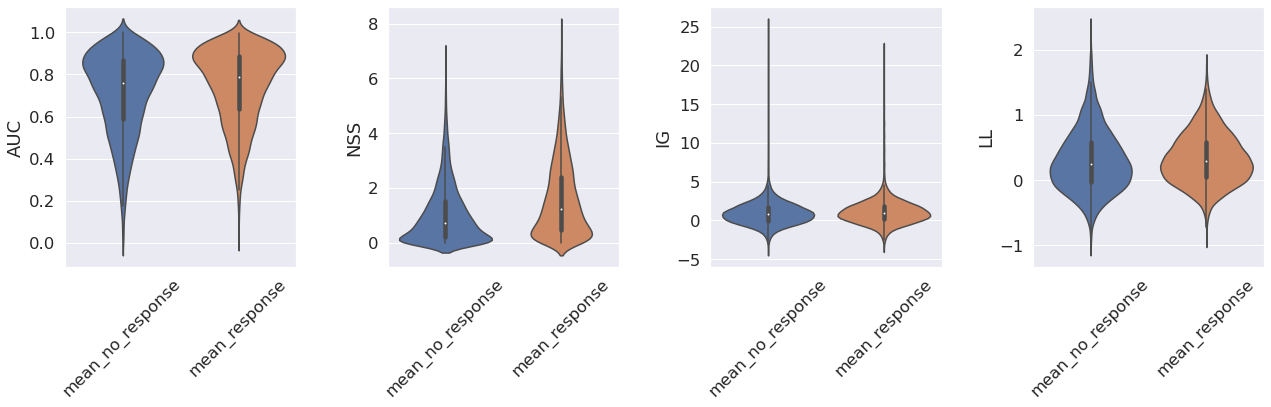

In [68]:
def compare_model_response_pred_metrics(df, cols_to_compare):
    _, axs = plt.subplots(1,4, figsize=(18,6))
    for ax, met in zip(axs.ravel(), df.metric.unique()):
        aux = df[df.metric==met][cols_to_compare]
        sns.violinplot(data=aux,ax=ax)
        ax.set_ylabel(met)
        ax.set_xticklabels(cols_to_compare, rotation=45) #ax.get_xticks()
    plt.tight_layout()

compare_model_response_pred_metrics(df_out, ['mean_no_response', 'mean_response'])

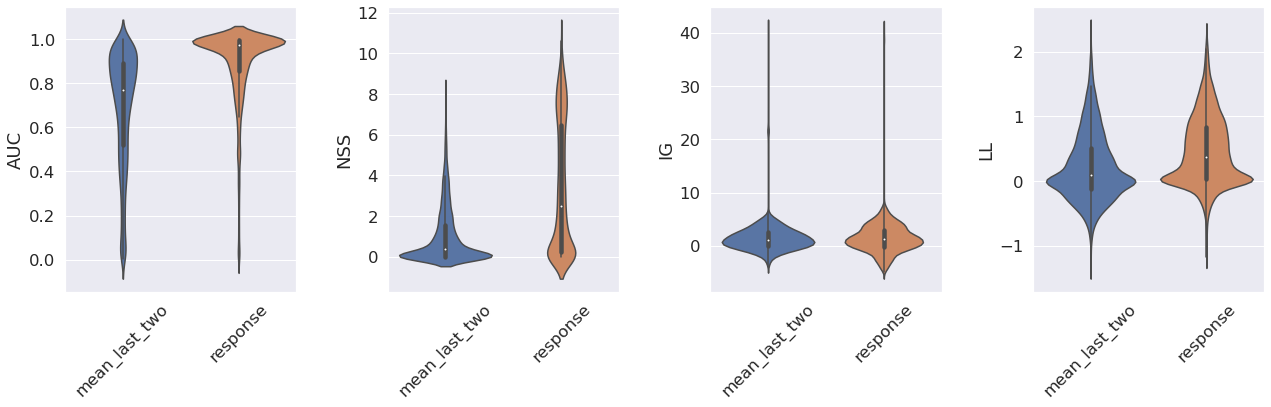

In [64]:
compare_model_response_pred_metrics(df_out, ['mean_last_two','response'])

## Comparación por tipo de trial

/home/gastonb/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


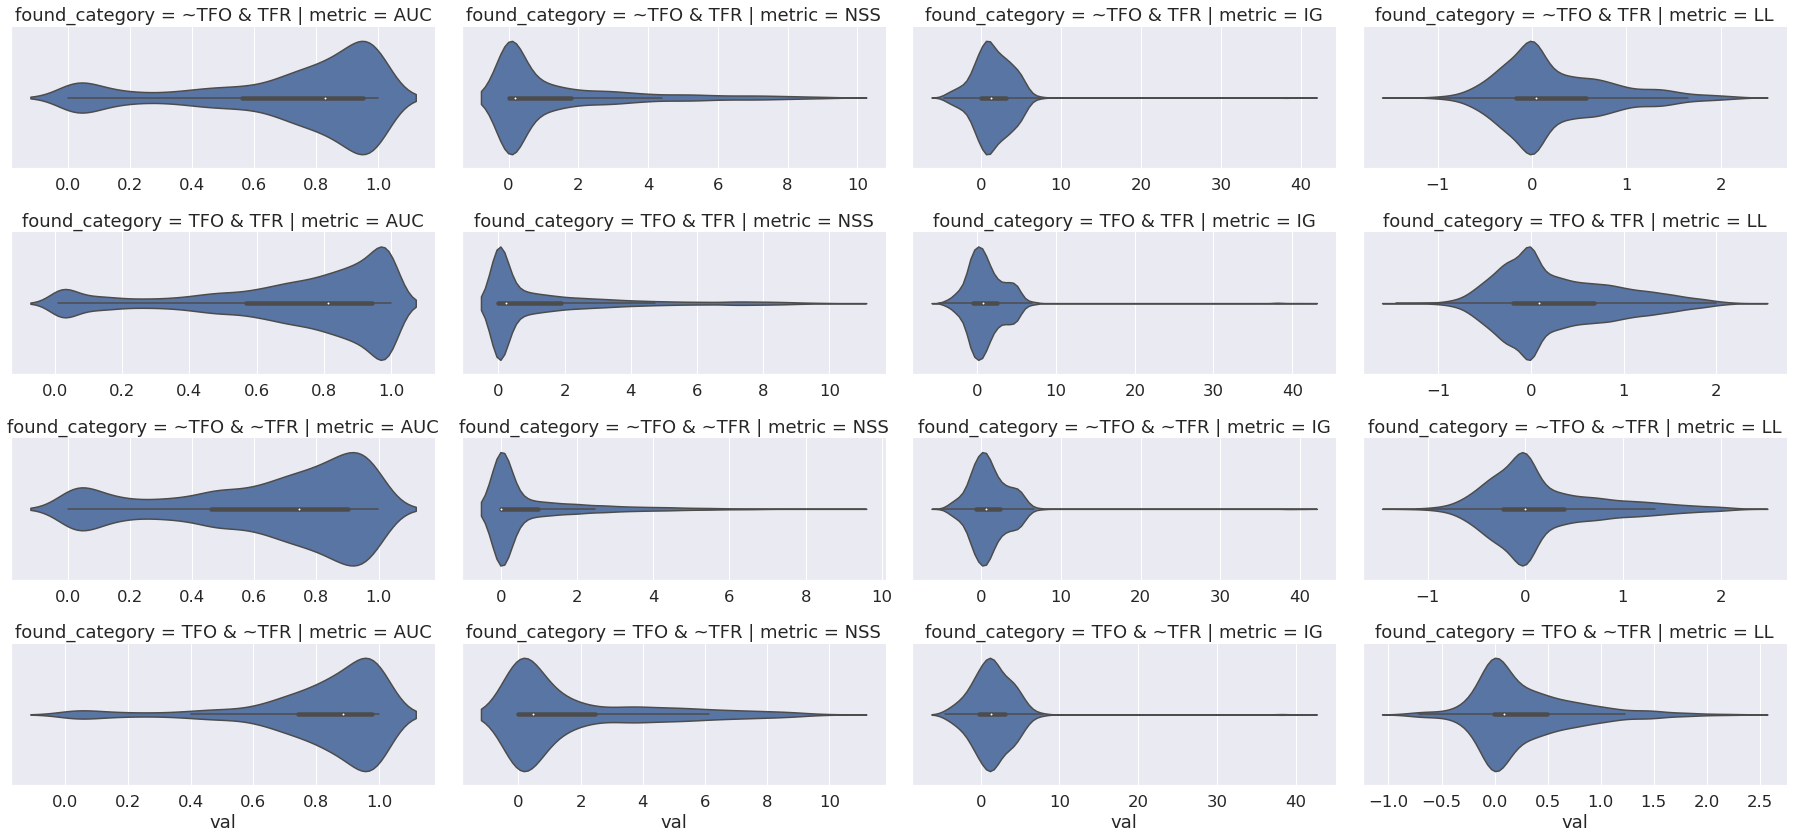

In [67]:
grid = sns.FacetGrid(df_all, col='metric', row='found_category',
                    palette="GnBu_d", height=3, aspect=2.1, sharex=False)

bins_hist = np.linspace(-4,4,30)
grid.map(sns.violinplot, 'val', stat='percent', alpha=0.8, common_norm=False);

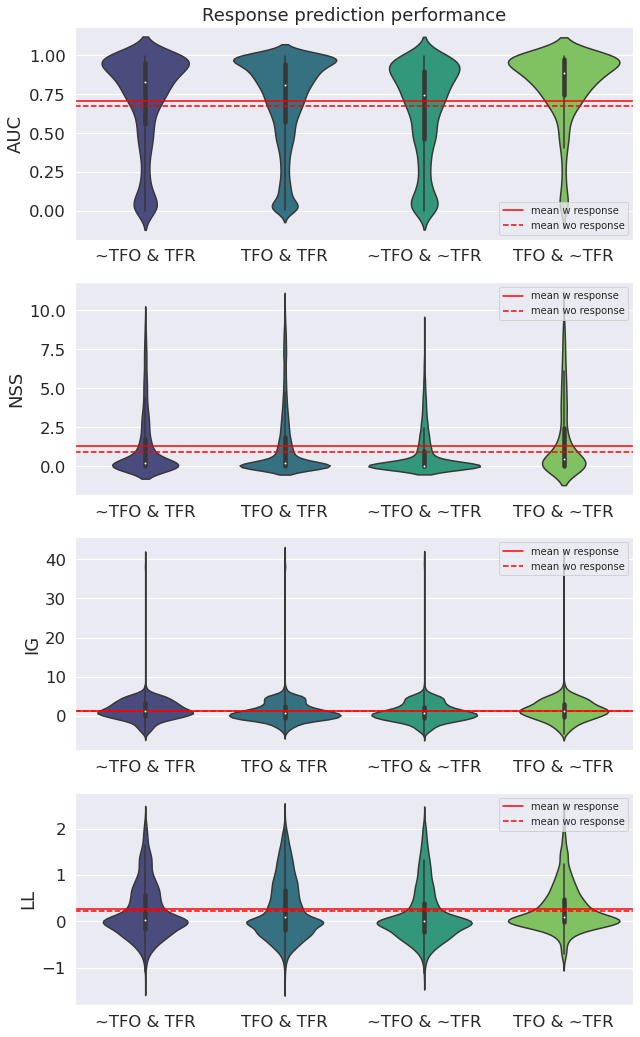

In [37]:
# AGREGAR EN CADA GRAFICO
# linea que sea la media del modelo para cada 

_, axs = plt.subplots(4,1, figsize=(10,18))
VAR = 'val'
axs[0].set_title('Response prediction performance');
for ax, met in zip(axs.ravel(), df_all.metric.unique()):
    aux = df_all.query('metric==@met')
    aux = aux[~aux.mean_no_response.isna()]
    #sns.histplot(x='response',hue='target_found', data=aux, ax=ax, stat='percent', common_norm=False)
    sns.violinplot(y=VAR, x='found_category', data=aux, ax=ax, palette='viridis')
    #sns.catplot(y=met, hue='target_found', data=aux, ax=ax)
    lines = []
    lines.append(ax.axhline(aux.mean_response.mean(),color='red',ls='-', label='mean w response'))
    lines.append(ax.axhline(aux.mean_no_response.mean(),color='red',ls='--', label = 'mean wo response'))
    #leg = Legend(ax, lines, ['mean response', 'mean no response'], frameon=False, loc='center',fontsize=12)
    #ax.add_artist(leg)
    ax.legend(prop={'size': 10})
    ax.set_ylabel(met)
    ax.set_xlabel('')

In [38]:
df_all[(df_all.metric==met) & (df_all.nsacc.isin(['response','last']))].head()

subj                             img metric     nsacc  \
6      1  grayscale_1_housebeautiful.jpg     LL      last   
7      1  grayscale_1_housebeautiful.jpg     LL  response   
14     1         grayscale_1_kitchen.jpg     LL      last   
15     1         grayscale_1_kitchen.jpg     LL  response   
22     1           grayscale_1_oliva.jpg     LL      last   

    subj_model_distance  nss_subj  nss_model   map_min   map_max  map_mean  \
6              1.000000  5.124688   7.814689  0.281429  0.326727  0.305867   
7              1.414214  0.351543   0.433908  0.425230  0.462614  0.461476   
14            16.124515  0.811794   6.146613  0.010120  0.053109  0.014385   
15             0.000000  9.522324   9.522324  0.095728  0.158703  0.105442   
22            13.000000  0.833679   4.588415  0.006270  0.041730  0.010588   

    ...  distance_to_last_fix  delta_time_response  response_x response_y  \
6   ...             78.365809             0.466865       186.0      199.0   
7   ...             78.365809             0.466865       186.0      199.0   
14  ...             59.573148             0.666899       883.0      313.0   
15  ...             59.573148             0.666899       883.0      313.0   
22  ...             38.296997             0.566944       153.0      627.0   

   n_fix       val  mean_response  mean_no_response  mean_last_two  \
6      8  0.063124       0.251722          0.287270       0.238036   
7      8  0.002880       0.251722          0.287270       0.238036   
14     6  0.438859       0.258111          0.191759       0.123111   
15     6  0.589875       0.258111          0.191759       0.123111   
22     5  0.617651       0.355577          0.124822       0.178579   

    found_category  
6       ~TFO & TFR  
7       ~TFO & TFR  
14       TFO & TFR  
15       TFO & TFR  
22       TFO & TFR  

[5 rows x 27 columns]

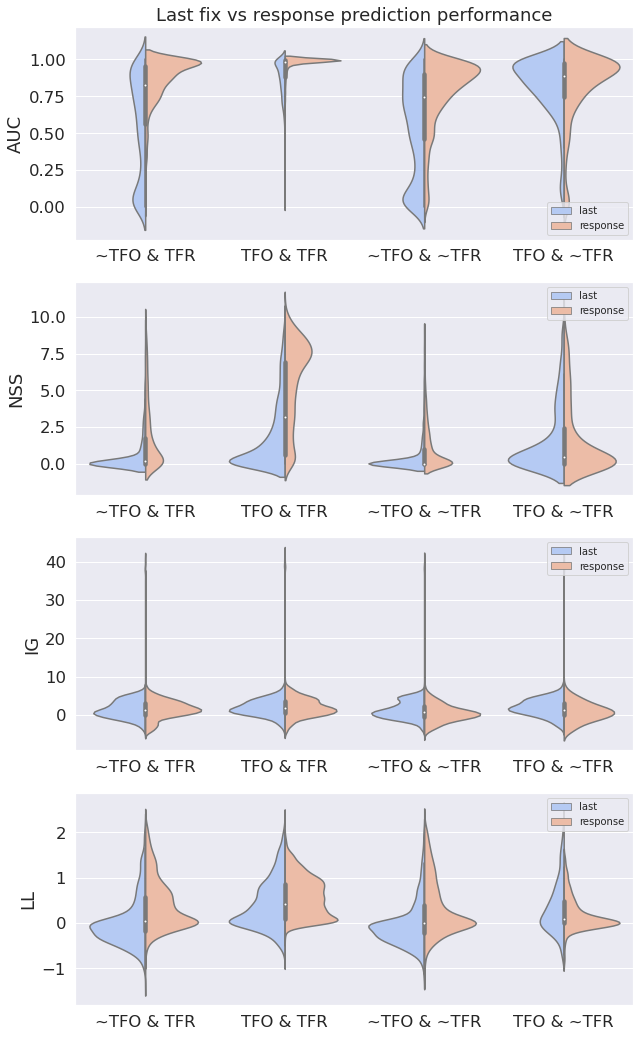

In [35]:
_, axs = plt.subplots(4,1, figsize=(10,18))
VAR = 'val'
axs[0].set_title('Last fix vs response prediction performance');
for ax, met in zip(axs.ravel(), df_all.metric.unique()):
    aux = df_all[(df_all.metric==met) & (df_all.nsacc.isin(['response','last']))]
    aux = aux[~aux.mean_no_response.isna()]
    #sns.histplot(x='response',hue='target_found', data=aux, ax=ax, stat='percent', common_norm=False)
    sns.violinplot(y=VAR, x='found_category',hue='nsacc',split=True, data=aux, ax=ax, palette='coolwarm')
    #sns.catplot(y=met, hue='target_found', data=aux, ax=ax)
    lines = []
    #lines.append(ax.axhline(aux.mean_response.mean(),color='red',ls='-', label='mean response'))
    #lines.append(ax.axhline(aux.mean_no_response.mean(),color='red',ls='--', label = 'mean wo response'))
    #leg = Legend(ax, lines, ['mean response', 'mean no response'], frameon=False, loc='center',fontsize=12)
    #ax.add_artist(leg)
    ax.legend(prop={'size': 10})
    ax.set_ylabel(met)
    ax.set_xlabel('')

## Distancia al modelo

In [36]:
# no se porque tengo duplicada la columna de subj_model_distance
print(df.shape, df_all.shape)

df = df.loc[:,~df.columns.duplicated()].copy()
print(df.shape)
df_all = df_all.loc[:,~df_all.columns.duplicated()].copy()
print(df_all.shape)

(58504, 16) (173384, 27)
(58504, 16)
(173384, 27)


<AxesSubplot:ylabel='Frequency'>

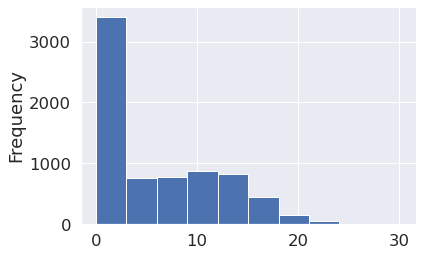

In [37]:
df[(df.nsacc=='response') & (df.metric=='LL')]['subj_model_distance'].plot(kind='hist')

In [38]:
aux = df_all[(df_all.metric=='LL') & (df_all.nsacc.isin(['response','last']))]
print(aux.shape)
aux.head()

(14626, 27)


subj                             img metric     nsacc  \
6      1  grayscale_1_housebeautiful.jpg     LL      last   
7      1  grayscale_1_housebeautiful.jpg     LL  response   
14     1         grayscale_1_kitchen.jpg     LL      last   
15     1         grayscale_1_kitchen.jpg     LL  response   
22     1           grayscale_1_oliva.jpg     LL      last   

    subj_model_distance  nss_subj  nss_model   map_min   map_max  map_mean  \
6              1.000000  5.124688   7.814689  0.281429  0.326727  0.305867   
7              1.414214  0.351543   0.433908  0.425230  0.462614  0.461476   
14            16.124515  0.811794   6.146613  0.010120  0.053109  0.014385   
15             0.000000  9.522324   9.522324  0.095728  0.158703  0.105442   
22            13.000000  0.833679   4.588415  0.006270  0.041730  0.010588   

    ...  distance_to_last_fix  delta_time_response  response_x response_y  \
6   ...             78.365809             0.466865       186.0      199.0   
7   ...             78.365809             0.466865       186.0      199.0   
14  ...             59.573148             0.666899       883.0      313.0   
15  ...             59.573148             0.666899       883.0      313.0   
22  ...             38.296997             0.566944       153.0      627.0   

   n_fix       val  mean_response  mean_no_response  mean_last_two  \
6      8  0.063124       0.251722          0.287270       0.238036   
7      8  0.002880       0.251722          0.287270       0.238036   
14     6  0.438859       0.258111          0.191759       0.123111   
15     6  0.589875       0.258111          0.191759       0.123111   
22     5  0.617651       0.355577          0.124822       0.178579   

    found_category  
6       ~TFO & TFR  
7       ~TFO & TFR  
14       TFO & TFR  
15       TFO & TFR  
22       TFO & TFR  

[5 rows x 27 columns]

In [39]:
aux['subj_model_distance']

6         1.000000
7         1.414214
14       16.124515
15        0.000000
22       13.000000
           ...    
58487     6.708204
58494    19.104973
58495    18.027756
58502     2.236068
58503     2.000000
Name: subj_model_distance, Length: 14626, dtype: float64

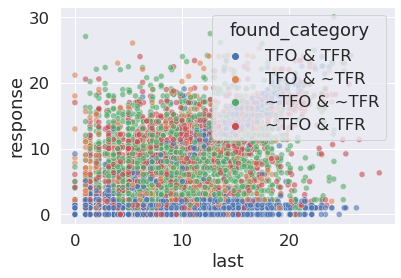

In [40]:
tabla_distancias = pd.pivot(aux[['subj', 'img','nsacc', 'subj_model_distance','found_category']], 
                            index=['subj', 'img','found_category'], columns='nsacc', values='subj_model_distance').reset_index()
sns.scatterplot(data=tabla_distancias, hue='found_category', x='last', y ='response', alpha=0.6)
plt.show()

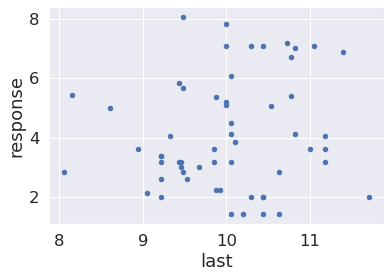

In [48]:
tabla_distancias.groupby(by='subj').median().plot(kind='scatter', x='last', y ='response',c='b')
plt.show()

In [50]:
tabla_distancias[['last', 'response']].corr()

nsacc        last  response
nsacc                      
last      1.00000   0.34487
response  0.34487   1.00000

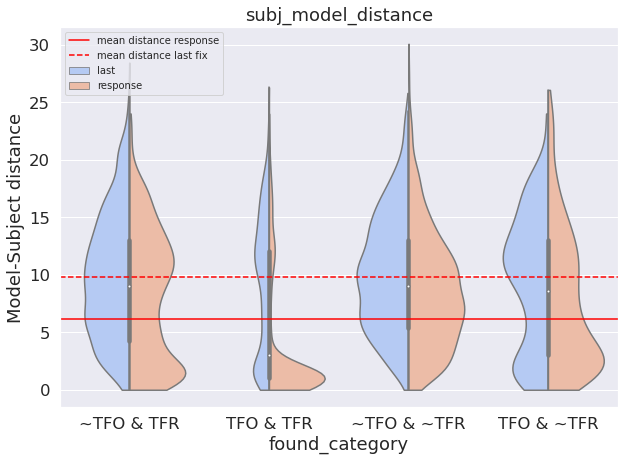

In [42]:
_, ax = plt.subplots(1,1, figsize=(10,7))
VAR = 'subj_model_distance'
ax.set_title(f'{VAR}');
aux = aux[~aux.mean_no_response.isna()]
sns.violinplot(y=VAR, x='found_category',hue='nsacc',split=True, data=aux, ax=ax, cut=0, palette='coolwarm')
mean_dist_response = aux[VAR][aux.nsacc=='response'].mean() 
mean_dist_last     = aux[VAR][aux.nsacc=='last'].mean()
ax.axhline(mean_dist_response,color='red',ls='-', label='mean distance response')
ax.axhline(mean_dist_last,color='red',ls='--', label='mean distance last fix')
ax.legend(prop={'size': 10});
ax.set_ylabel('Model-Subject distance');

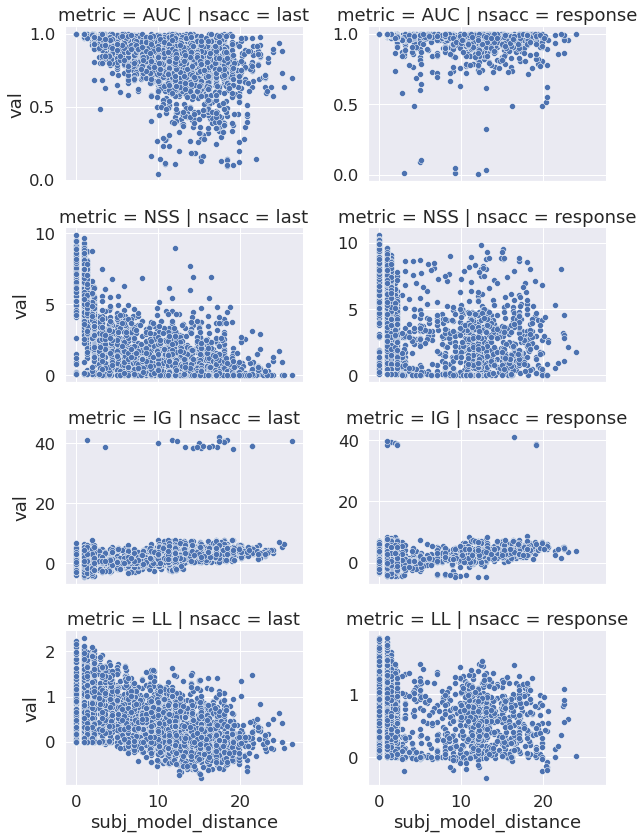

In [62]:
aux = df_all.query('found_category == "TFO & TFR"').query('nsacc == "last" or nsacc=="response"')[['subj','img','nsacc','metric','val','subj_model_distance','found_category']]
g = sns.FacetGrid(aux, col='nsacc', row='metric', sharey=False, height=3, aspect=1.5)
g.map(sns.scatterplot, 'subj_model_distance', 'val')

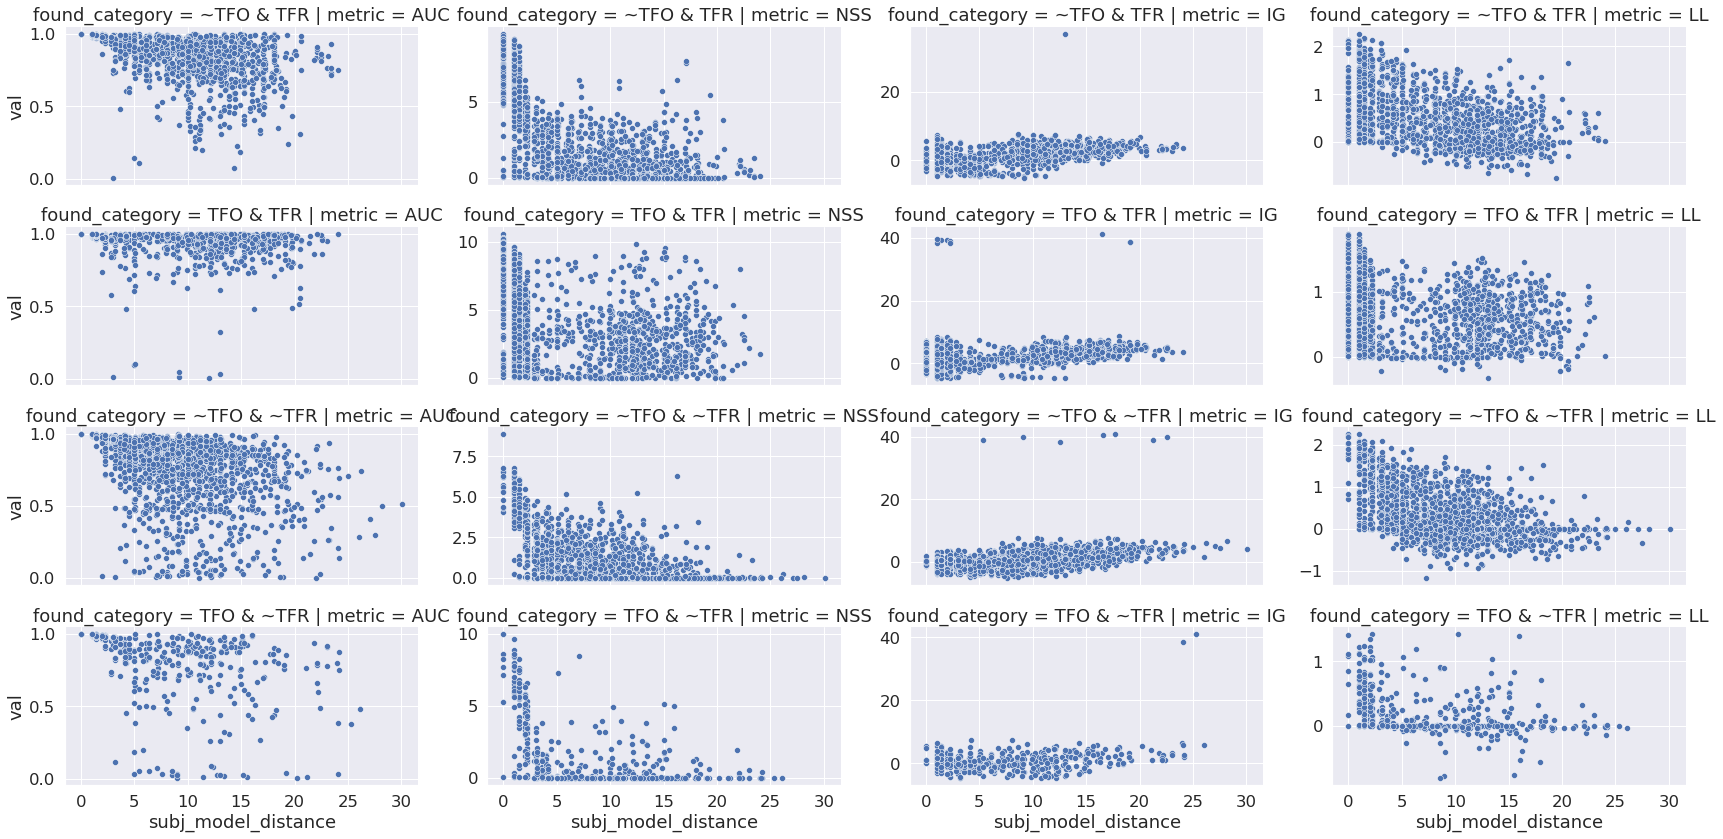

In [64]:
aux = df_all.query('nsacc=="response"')[['subj','img','nsacc','metric','val','subj_model_distance','found_category']]
g = sns.FacetGrid(aux, row='found_category', col='metric', sharey=False, height=3, aspect=2)
g.map(sns.scatterplot, 'subj_model_distance', 'val')

Una cosa que podemos mirar es rendimiento por rango de fijaciones. Para cada rango de fijación tengo una distribución de scores (una distribución para cada métrica), la pregunta es si la distribución de las respuestas es distinta o no a la 

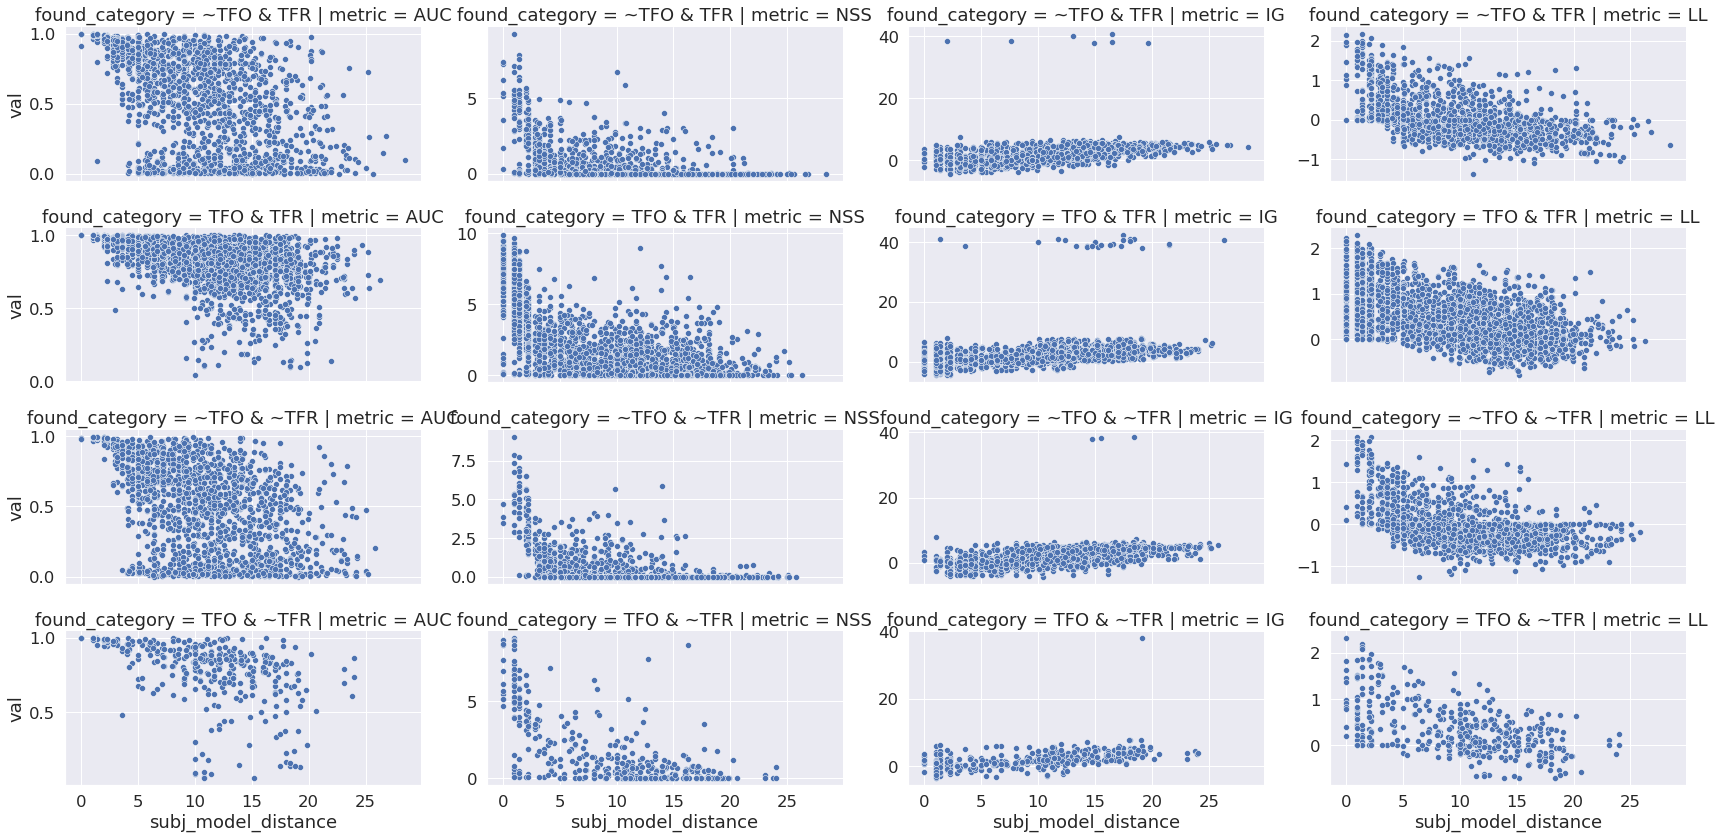

In [65]:
aux = df_all.query('nsacc=="last"')[['subj','img','nsacc','metric','val','subj_model_distance','found_category']]
g = sns.FacetGrid(aux, row='found_category', col='metric', sharey=False, height=3, aspect=2)
g.map(sns.scatterplot, 'subj_model_distance', 'val')

### mirando respuesta, tamanio y nss

In [43]:
aux = df_all.query('nsacc=="response"')[['subj','img','nsacc','metric','val', 'nss_subj',
                'nss_model', 'map_min', 'map_max', 'map_mean', 'map_std','subj_model_distance','found_category', 'response_size']]
aux['nss_diff'] = aux['nss_model'] - aux['nss_subj']
aux.columns

Index(['subj', 'img', 'nsacc', 'metric', 'val', 'nss_subj', 'nss_model',
       'map_min', 'map_max', 'map_mean', 'map_std', 'subj_model_distance',
       'found_category', 'response_size', 'nss_diff'],
      dtype='object')

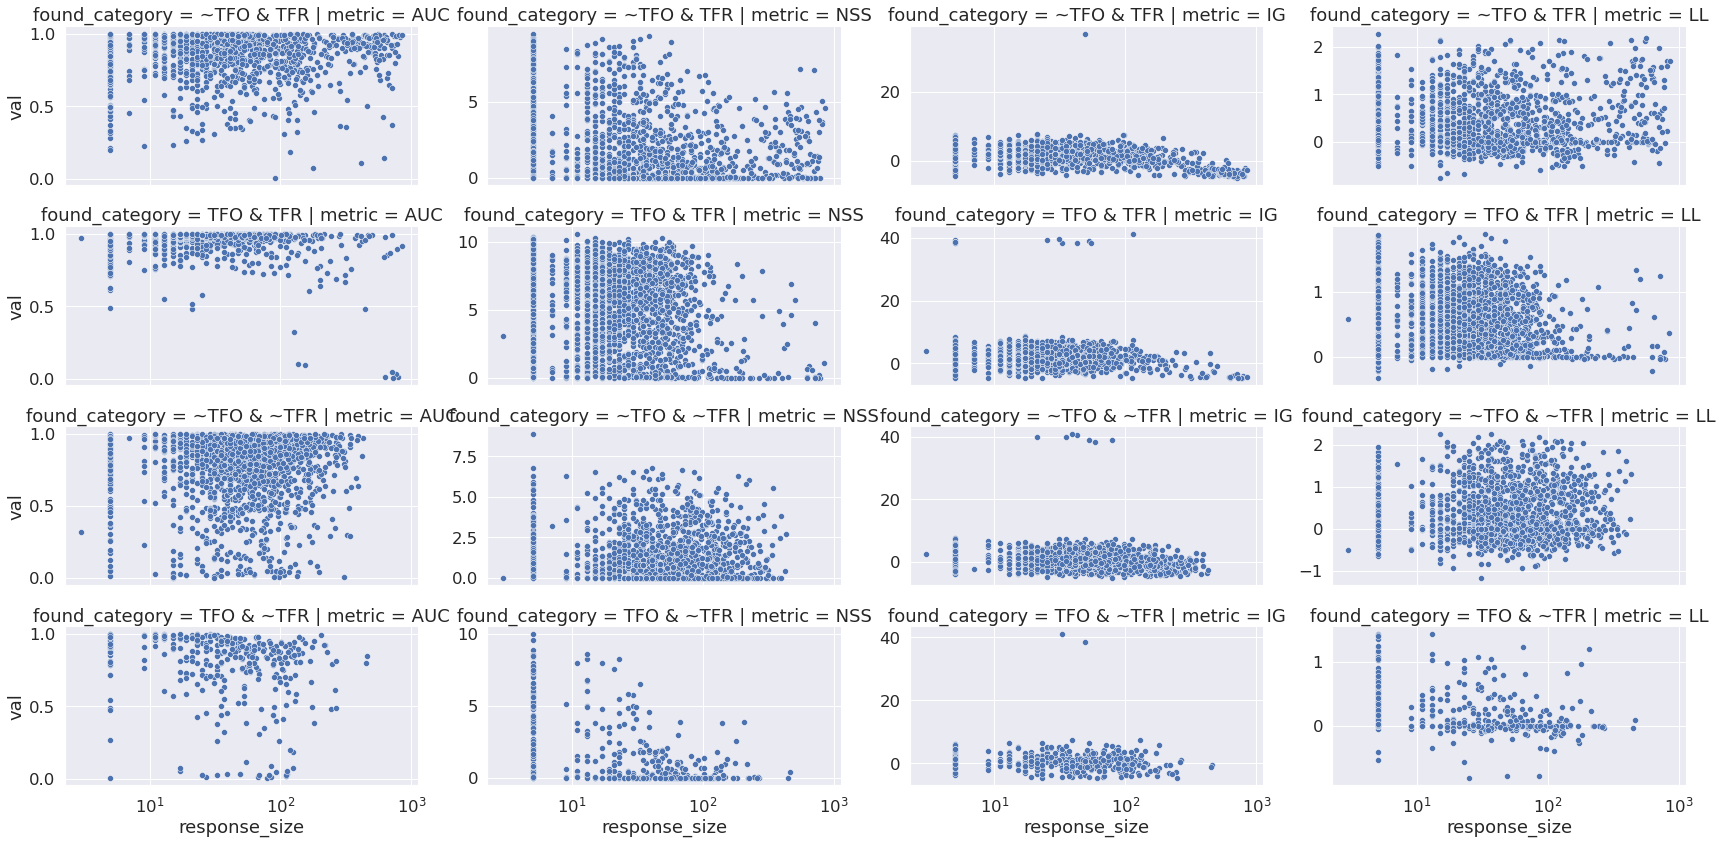

In [44]:
#
g = sns.FacetGrid(aux, row='found_category', col='metric', sharey=False, height=3, aspect=2)
g.map(sns.scatterplot, 'response_size','val').set(xscale = 'log')

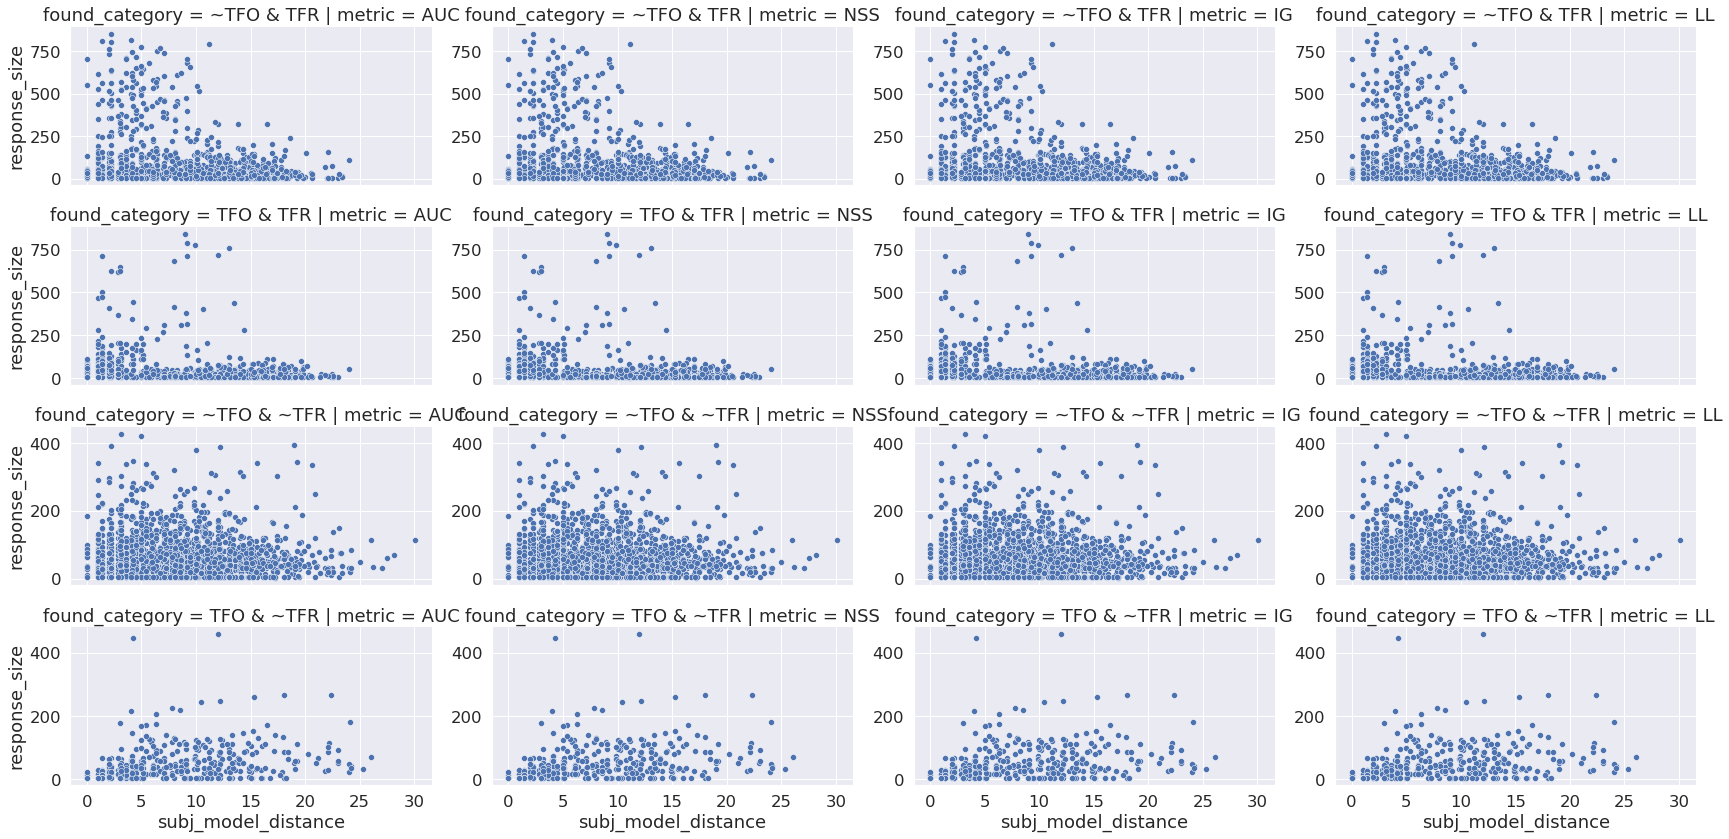

In [69]:
g = sns.FacetGrid(aux, row='found_category', col='metric', sharey=False, height=3, aspect=2)
g.map(sns.scatterplot,'subj_model_distance','response_size')

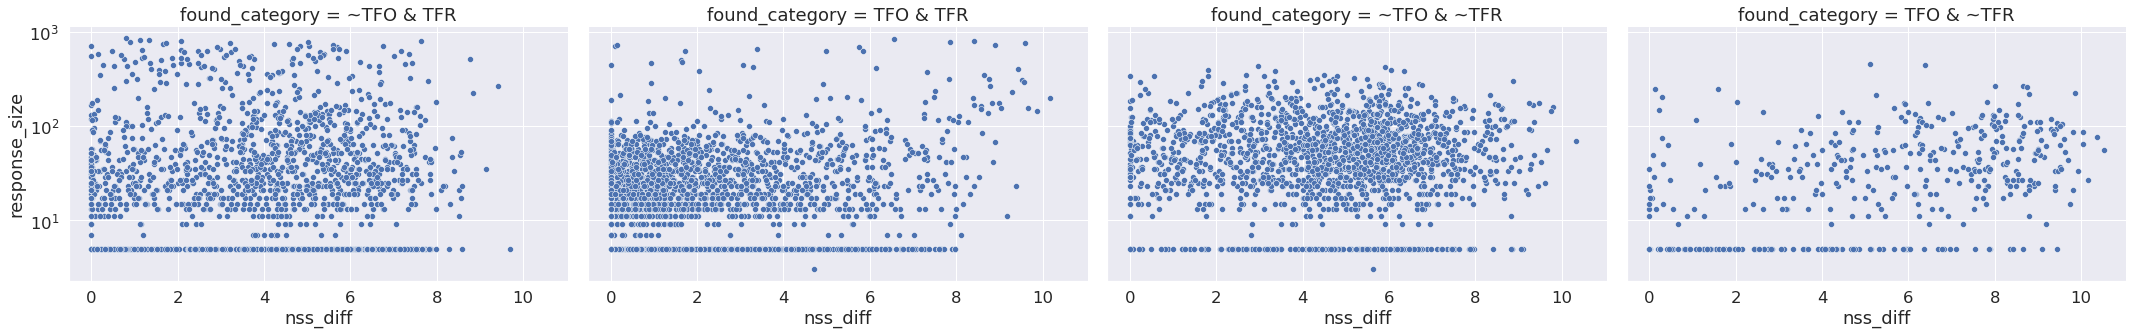

In [70]:
#
g = sns.FacetGrid(aux.query('metric=="NSS"'), col='found_category', height=5, aspect=1.5)
g.map(sns.scatterplot, 'nss_diff','response_size').set(yscale = 'log')

## Desagregando trials

Tengo que separar en nuevas dos categorias, vio el trial online y siguió

In [ ]:
df_all[df_all.nsacc.isin(['responses', 'last'])]

# Debug

Hay algo raro en como estan quedando los mapas guardados en cada paso intermedio, algunos ejemplos medios raros:
- 1, grayscale_1_housebeautiful
- d

Parece que si miras los últimos da algo con un poco de sentido pero despues no, parece que hay algun efecto extraño en los mapas, no cambian mucho o se vuelven constantes, o tienen las esquinas en negro

In [46]:
df_all.columns

Index(['subj', 'img', 'metric', 'nsacc', 'subj_model_distance', 'nss_subj',
       'nss_model', 'map_min', 'map_max', 'map_mean', 'map_std',
       'max_fixations', 'scanpath_length', 'target_found',
       'target_found_response', 'response_size', 'distance_to_target',
       'distance_to_last_fix', 'delta_time_response', 'response_x',
       'response_y', 'n_fix', 'val', 'mean_response', 'mean_no_response',
       'mean_last_two', 'found_category'],
      dtype='object')

Total saccades: 12


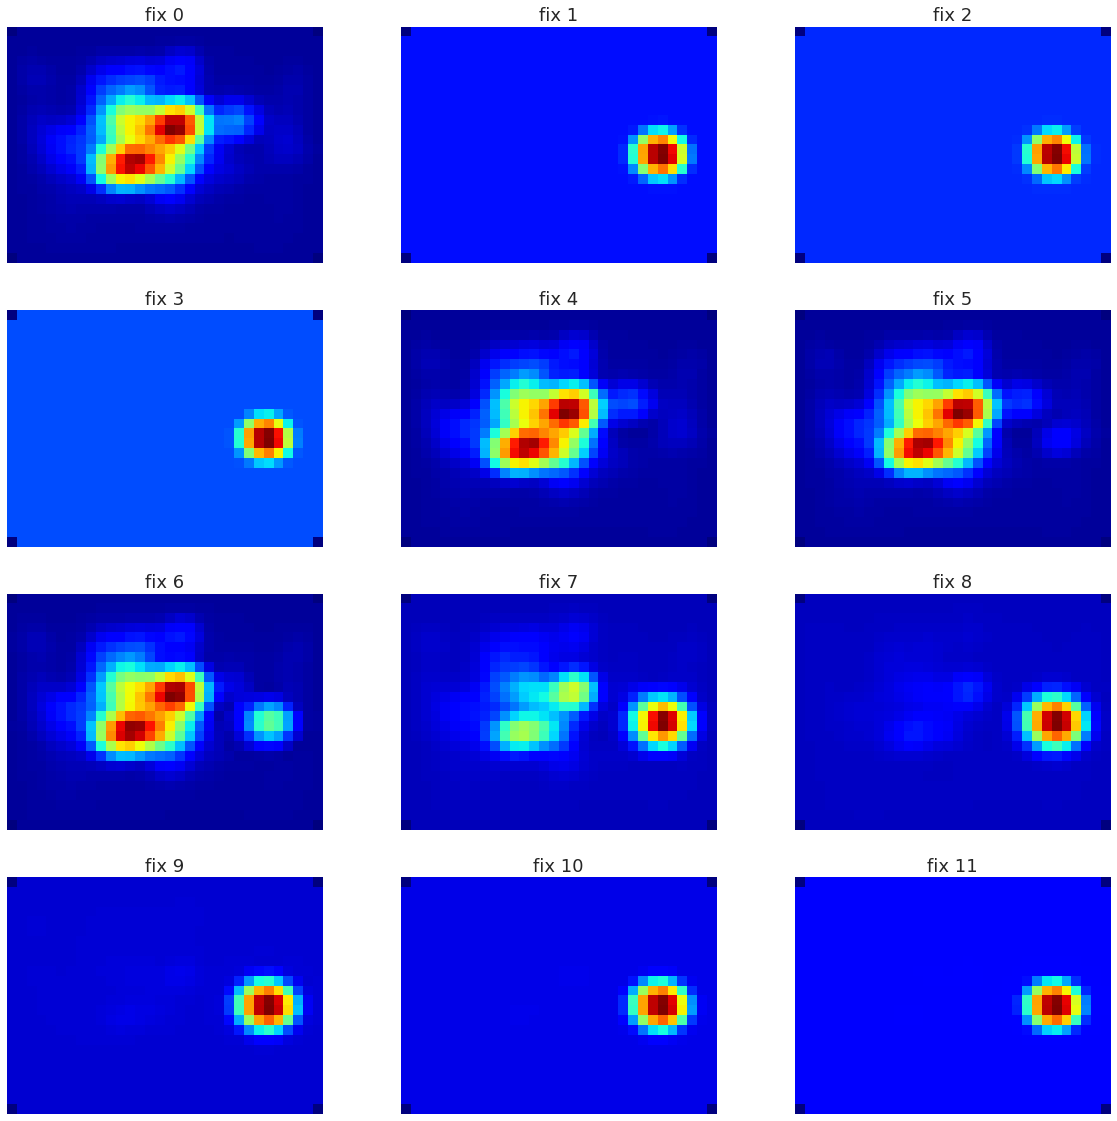

In [44]:
def plot_all_fixation_maps(fixation_maps, img_name, results_path):
    # Plot all fixation maps
    n_fixs = len(fixation_maps)
    n_rows = int(np.ceil(n_fixs/3))
    fig, axes = plt.subplots(n_rows, 3, figsize=(20, 5*n_rows))
    for i,  fix_map in enumerate(fixation_maps):
        row = int(i/3)
        col = i%3
        ax = axes[row, col]
        ax.imshow(fix_map, cmap='jet')
        ax.set_title(f'fix {i}')
        ax.axis('off')
    #fig.savefig(os.path.join(results_path, f'{img_name}_fixation_maps.png'))
    plt.show()

# Miremos algunos mapas
# tmp = load_fixation_maps(1, 'grayscale_1_housebeautiful.jpg',results_path)
# tmp = load_fixation_maps(44, 'grayscale_1_housebeautiful.jpg',results_path)
tmp = load_fixation_maps(10, 'grayscale_98_oliva.jpg',results_path)
plot_all_fixation_maps(tmp, 'grayscale_98_oliva.jpg', results_path)

In [46]:
tmp[-2].shape

(24, 32)